In [5]:
# !unzip "data.zip"

Archive:  data.zip
  inflating: Bearing_Sensor_Data/2004.02.12.10.52.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.02.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.12.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.22.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.32.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.42.39  
  inflating: Bearing_Sensor_Data/2004.02.12.11.52.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.02.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.12.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.22.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.32.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.42.39  
  inflating: Bearing_Sensor_Data/2004.02.12.12.52.39  
  inflating: Bearing_Sensor_Data/2004.02.12.13.02.39  
  inflating: Bearing_Sensor_Data/2004.02.12.13.12.39  
  inflating: Bearing_Sensor_Data/2004.02.12.13.22.39  
  inflating: Bearing_Sensor_Data/2004.02.12.13.32.39  
  inflating: Bearing_Sensor_Data/2004.02.12.13

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# 재현성을 위한 랜덤 시드 설정
seed(10)
tf.random.set_seed(10)

In [ ]:
# 데이터 파일이 있는 디렉토리 경로
data_dir = "./Bearing_Sensor_Data"

# 데이터프레임을 저장할 리스트 생성
data_list = []

# 모든 파일을 순회하며 데이터프레임으로 병합
for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_df = pd.DataFrame(dataset_mean_abs.reshape(1, 4), index=[filename])
    # 리스트에 데이터프레임 추가
    data_list.append(dataset_df)

# 리스트에 있는 모든 데이터프레임을 한 번에 합치기
merged_data = pd.concat(data_list)

# 컬럼명 재설정
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data = merged_data.sort_index()

print("전체 데이터셋 크기:", merged_data.shape)
merged_data.head()

전체 데이터셋 크기: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.10.52.39,0.060236,0.074227,0.083926,0.044443
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118
2004.02.12.11.22.39,0.061665,0.073279,0.084879,0.044172
2004.02.12.11.32.39,0.061944,0.074593,0.082626,0.044659


--- 데이터 날짜 범위 확인 ---
데이터 시작 날짜: 2004-02-12 10:52:39
데이터 끝 날짜: 2004-02-19 06:22:39
--------------------------

학습 데이터셋 크기: (445, 4)
테스트 데이터셋 크기: (538, 4)


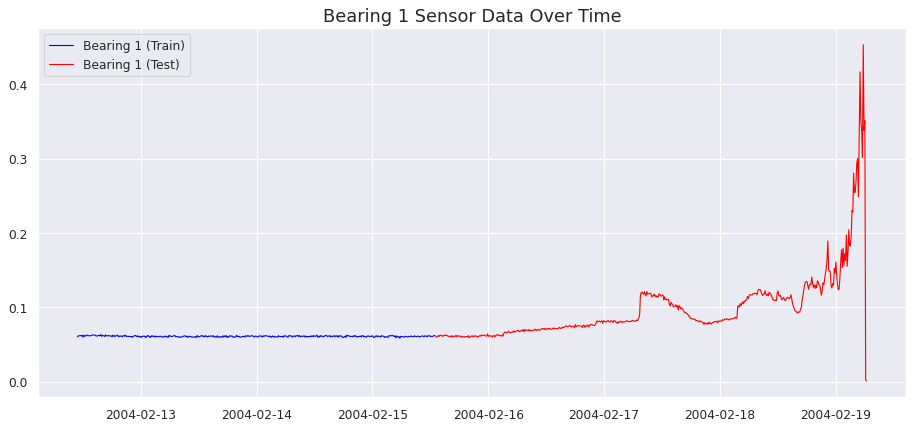

In [ ]:
# 파일명을 datetime 객체로 변환하고 시간 순으로 정렬
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()

# 실제로 로드된 데이터의 시작과 끝 날짜를 확인합니다.
print("--- 데이터 날짜 범위 확인 ---")
print("데이터 시작 날짜:", merged_data.index.min())
print("데이터 끝 날짜:", merged_data.index.max())
print("--------------------------\n")
# -------------------------

# 데이터 분할 (정상 상태와 고장 발생 시점)
# 위에서 확인된 날짜를 기준으로 이 부분을 수정해야 할 수 있습니다.
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("학습 데이터셋 크기:", train.shape)
print("테스트 데이터셋 크기:", test.shape)

# 전체 데이터 시계열 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1 (Train)', color='blue', linewidth=1)
ax.plot(test['Bearing 1'], label='Bearing 1 (Test)', color='red', linewidth=1)
ax.set_title('Bearing 1 Sensor Data Over Time', fontsize=16)
plt.legend()
plt.show()

In [ ]:
## 4. 데이터 정규화 및 LSTM 입력 형식 변환

# 데이터 정규화 (0~1 스케일)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# Scaler 저장 (나중에 재사용 가능)
joblib.dump(scaler, "scaler_data")

# LSTM 입력 형태로 변환 (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("학습 데이터 형태:", X_train.shape)
print("테스트 데이터 형태:", X_test.shape)

학습 데이터 형태: (445, 1, 4)
테스트 데이터 형태: (538, 1, 4)


In [ ]:
# LSTM Autoencoder 모델 정의
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # Encoder
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # Decoder
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# 모델 생성 및 컴파일
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

# 모델 학습
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

# 모델 저장
model.save("bearing-sensor-anomaly-detection.h5")
print("모델 저장 완료")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.4591 - val_loss: 0.3185
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3981 - val_loss: 0.2442
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3144 - val_loss: 0.1596
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1863 - val_loss: 0.1396
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1073 - val_loss: 0.1207
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1027 - val_loss: 0.1172
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1012 - val_loss: 0.1157
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1007 - val_loss: 0.1146
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1006 - val_loss: 0.1145
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1002 - val_loss: 0.1143
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0998 - val_loss: 0.1136
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

모델 저장 완료


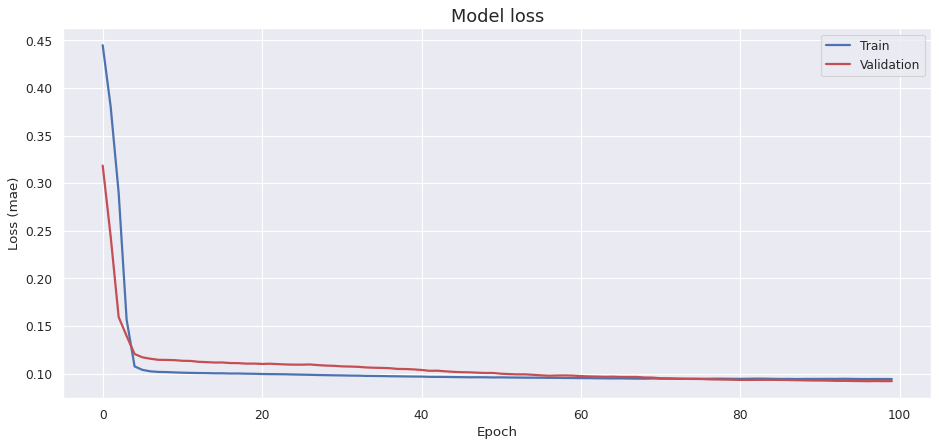

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


/tmp/ipython-input-389632902.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')


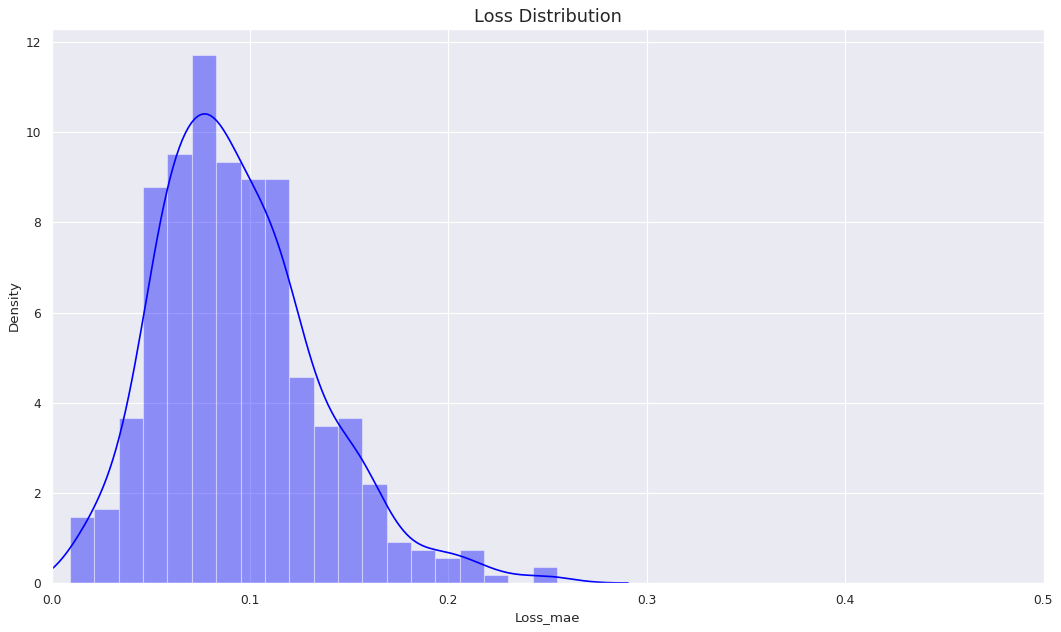

In [ ]:
# 학습 손실 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# 학습 데이터의 복원 오차 분포 확인
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0,.5])
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


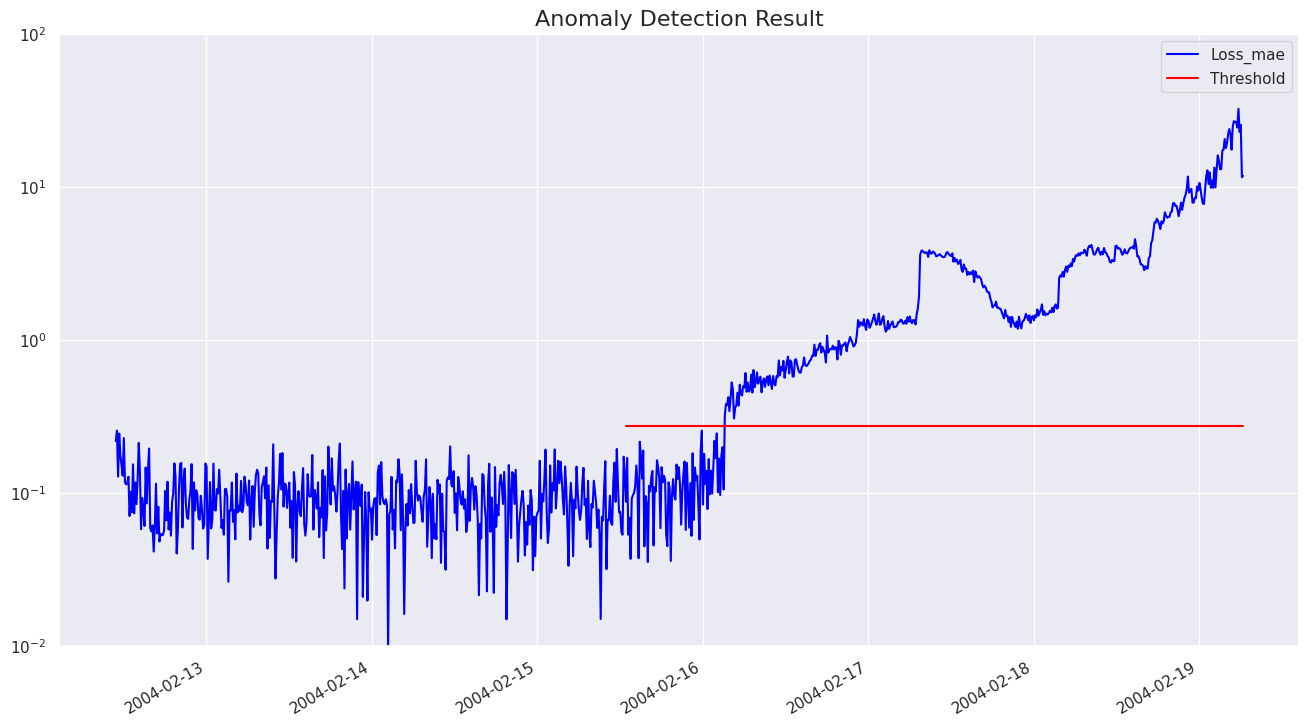

In [ ]:
# 테스트 데이터에 대한 복원 오차 계산
X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index

scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis=1)
scored_test['Threshold'] = 0.275  # 임계치 설정
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

# 전체 데이터(학습+테스트)의 복원 오차 및 이상치 시각화
scored_all = pd.concat([scored, scored_test[['Loss_mae', 'Threshold', 'Anomaly']]])
scored_all.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.title('Anomaly Detection Result', fontsize=16)
plt.show()

In [ ]:
# 실제 고장 발생 시점을 기준으로 ground truth 생성
actual_anomalies = scored_test.index > '2004-02-16 00:00:00'
predicted_anomalies = scored_test['Anomaly']

# 평가지표 계산
print("### Confusion Matrix ###")
print(confusion_matrix(actual_anomalies, predicted_anomalies))
print("\n### Classification Report ###")
print(classification_report(actual_anomalies, predicted_anomalies))
print(f"Accuracy: {accuracy_score(actual_anomalies, predicted_anomalies):.4f}")


### Confusion Matrix ###
[[ 67   0]
 [ 19 452]]

### Classification Report ###
              precision    recall  f1-score   support

       False       0.78      1.00      0.88        67
        True       1.00      0.96      0.98       471

    accuracy                           0.96       538
   macro avg       0.89      0.98      0.93       538
weighted avg       0.97      0.96      0.97       538

Accuracy: 0.9647
